In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl

1.Data

In [128]:
from tensorflow.keras.datasets import fashion_mnist
(x_train_set,y_train_set),(x_test,y_test)=fashion_mnist.load_data()

In [129]:
x_train_set=x_train_set.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0

In [130]:
x_train_set.shape,y_train_set.shape,x_test.shape,y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

7


<function matplotlib.pyplot.show(close=None, block=None)>

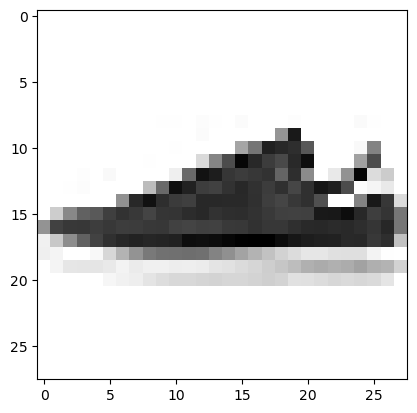

In [131]:
i=6
print(y_train_set[i])
plt.imshow(x_train_set[i],cmap='binary')
plt.show

In [132]:
from sklearn.model_selection import train_test_split

x_train,x_valid,y_train,y_valid=train_test_split(
    x_train_set,y_train_set,test_size=0.1,random_state=1)

In [133]:
x_train.shape,x_valid.shape

((54000, 28, 28), (6000, 28, 28))

GAN

build model

In [134]:
tf.random.set_seed(1)
np.random.seed(1)
d=30

In [135]:
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[d]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28*28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

gan = keras.models.Sequential([generator, discriminator])

In [136]:
generator.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 100)               3100      
                                                                 
 dense_37 (Dense)            (None, 150)               15150     
                                                                 
 dense_38 (Dense)            (None, 784)               118384    
                                                                 
 reshape_6 (Reshape)         (None, 28, 28)            0         
                                                                 
Total params: 136634 (533.73 KB)
Trainable params: 136634 (533.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [137]:
discriminator.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_39 (Dense)            (None, 150)               117750    
                                                                 
 dense_40 (Dense)            (None, 100)               15100     
                                                                 
 dense_41 (Dense)            (None, 1)                 101       
                                                                 
Total params: 132951 (519.34 KB)
Trainable params: 132951 (519.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [138]:
gan.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 28, 28)            136634    
                                                                 
 sequential_17 (Sequential)  (None, 1)                 132951    
                                                                 
Total params: 269585 (1.03 MB)
Trainable params: 269585 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


compile

In [139]:
discriminator.compile(loss="binary_crossentropy",optimizer="rmsprop")
discriminator.trainable=False
gan.compile(loss="binary_crossentropy",optimizer="rmsprop")

train

In [140]:
batch_size=32
dataset=tf.data.Dataset.from_tensor_slices(x_train)
dataset=dataset.shuffle(1000)
dataset=dataset.batch(batch_size,drop_remainder=True).prefetch(1)

In [141]:
def train_gan(gan, dataset, batch_size, d, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for x_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, d])
            generated_images = generator(noise)
            x_fake_and_real = tf.concat([generated_images, x_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(x_fake_and_real,y1)
            noise = tf.random.normal(shape=[batch_size, d])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images,10)

In [144]:
def plot_multiple_images(images,n=None):
    if images.shape[-1]==1:
        images=np.squeeze(images,axis=-1)
    plt.figure(figsize=(n,1))
    for i in range (n):
        plt.subplot(1,n,i+1)
        plt.imshow(images[i],cmap="binary")
        plt.axis("off")
    plt.show()
                 

Epoch 1/20


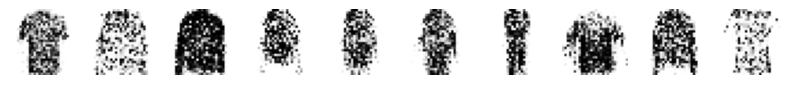

Epoch 2/20


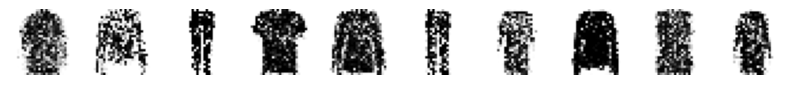

Epoch 3/20


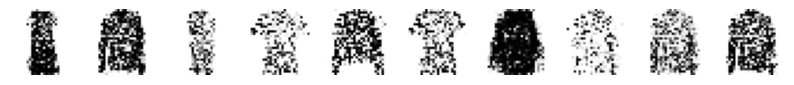

Epoch 4/20


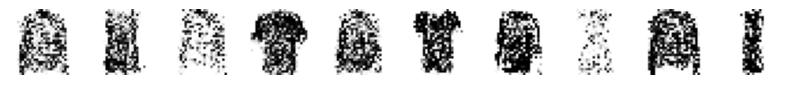

Epoch 5/20


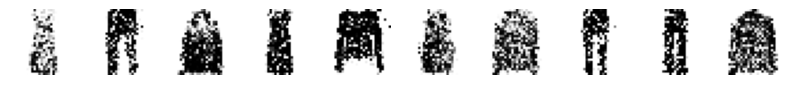

Epoch 6/20


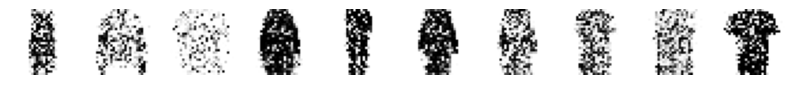

Epoch 7/20


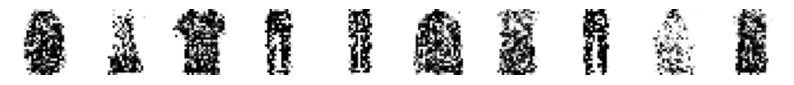

Epoch 8/20


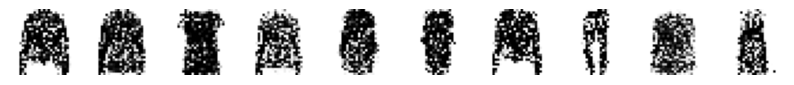

Epoch 9/20


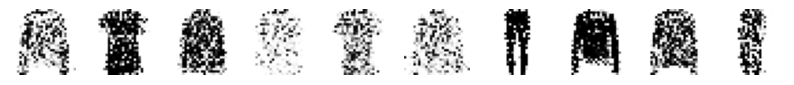

Epoch 10/20


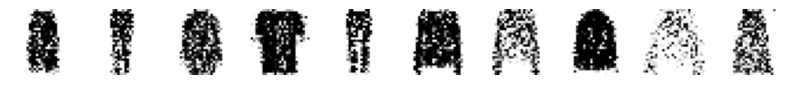

Epoch 11/20


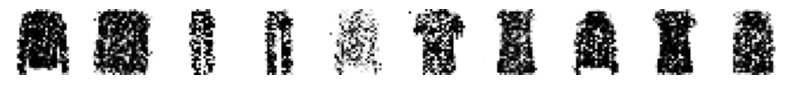

Epoch 12/20


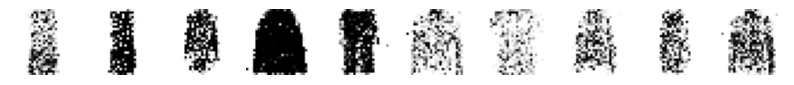

Epoch 13/20


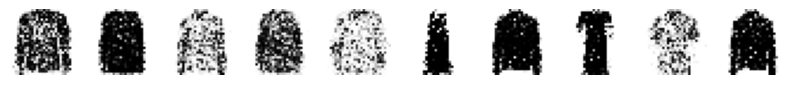

Epoch 14/20


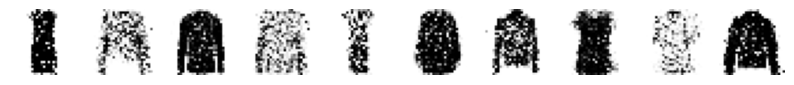

Epoch 15/20


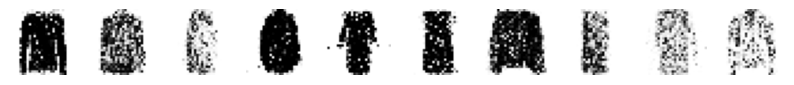

Epoch 16/20


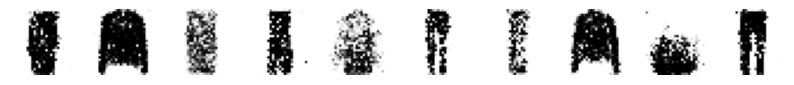

Epoch 17/20


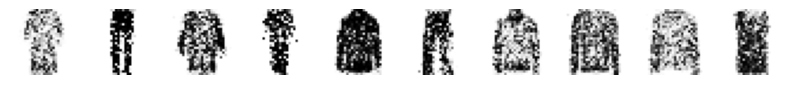

Epoch 18/20


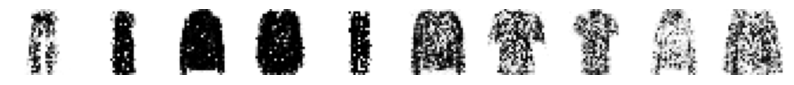

Epoch 19/20


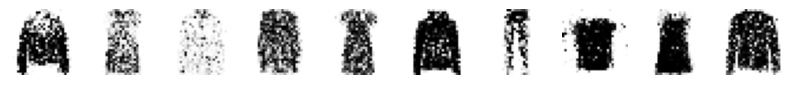

Epoch 20/20


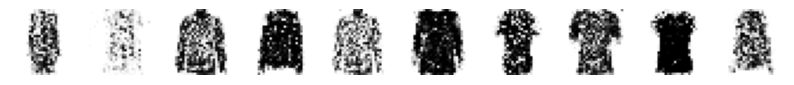

In [145]:
train_gan(gan, dataset, batch_size, d, n_epochs=20)

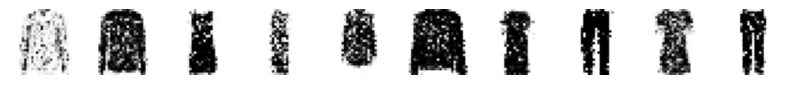

In [146]:
tf.random.set_seed(1)
np.random.seed(1)
noise = tf.random.normal(shape=[10, d])
generated_images = generator(noise)
plot_multiple_images(generated_images,10)

Deep convolutional GAN

In [134]:
tf.random.set_seed(1)
np.random.seed(1)
d=100

In [150]:
generator = keras.models. Sequential([
keras.layers.Dense(7*7*128, input_shape=[d]),
keras.layers.Reshape([7, 7, 128]),
keras.layers.BatchNormalization(),
keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME" ,
                            activation="selu"),
keras.layers.BatchNormalization(),
keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                            activation="tanh")
])
discriminator = keras.models. Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras. layers.Dropout(0.4),
    keras. layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras. layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan=keras.models. Sequential([generator,discriminator])

In [151]:
discriminator.compile(loss="binary_crossentropy",optimizer="rmsprop")
discriminator.trainable=False
gan.compile(loss="binary_crossentropy",optimizer="rmsprop")

In [153]:
x_train_dcgan = x_train.reshape(-1, 28, 28, 1) * 2. -1.

In [154]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/20


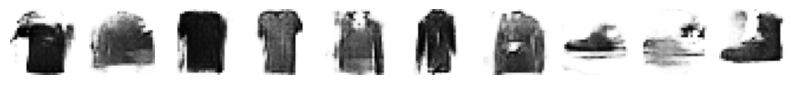

Epoch 2/20


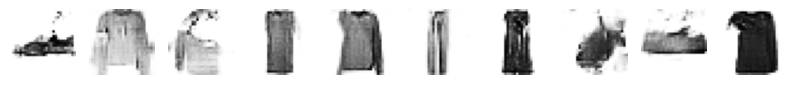

Epoch 3/20


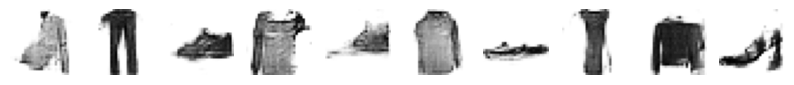

Epoch 4/20


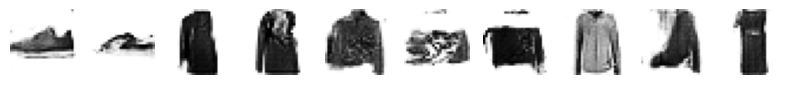

Epoch 5/20


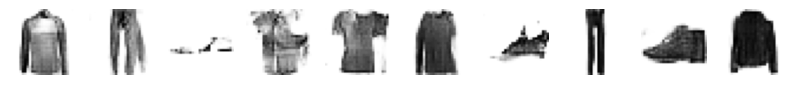

Epoch 6/20


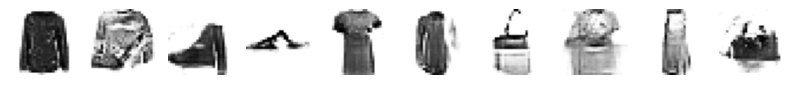

Epoch 7/20


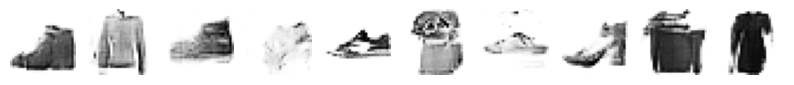

Epoch 8/20


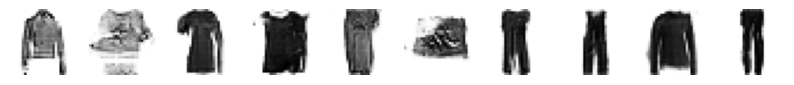

Epoch 9/20


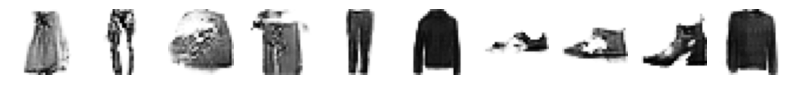

Epoch 10/20


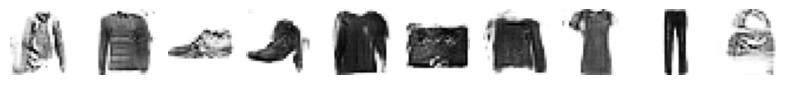

Epoch 11/20


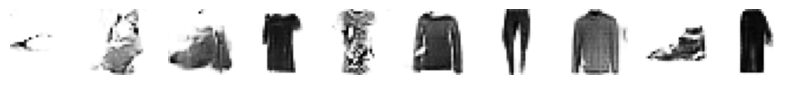

Epoch 12/20


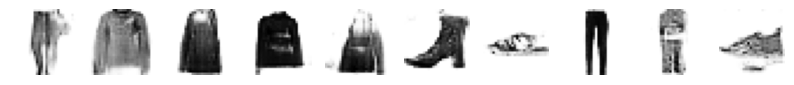

Epoch 13/20


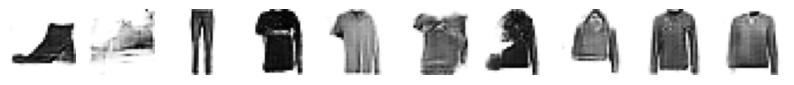

Epoch 14/20


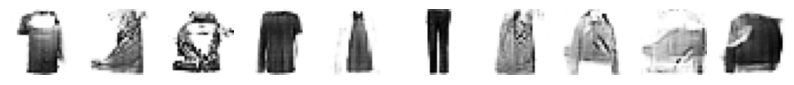

Epoch 15/20


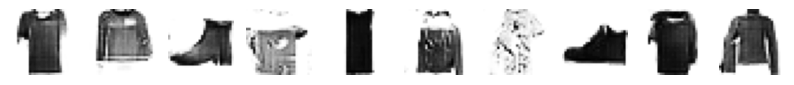

Epoch 16/20


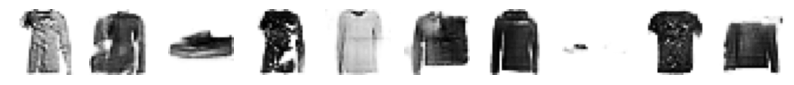

Epoch 17/20


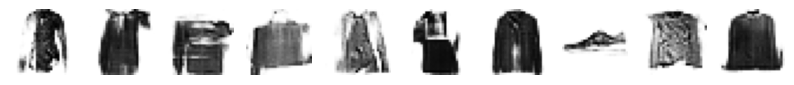

Epoch 18/20


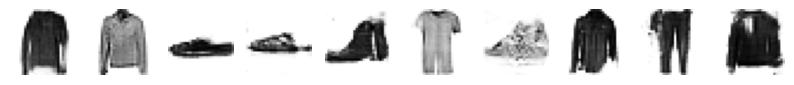

Epoch 19/20


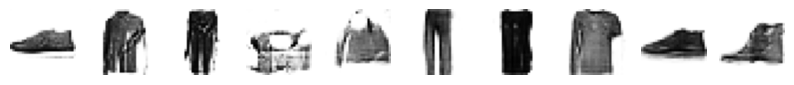

Epoch 20/20


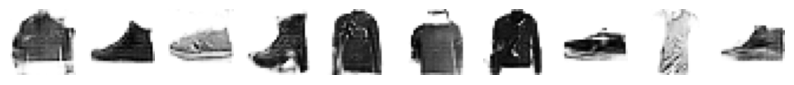

In [155]:
train_gan(gan, dataset, batch_size, d, n_epochs=20)

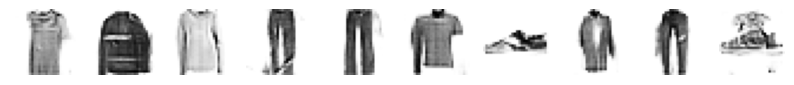

In [156]:
tf.random.set_seed(1)
np.random.seed(1)
noise = tf.random.normal(shape=[10, d])
generated_images = generator(noise)
plot_multiple_images(generated_images,10)